Training data: (22750, 9)
Testing data: (12250, 8)


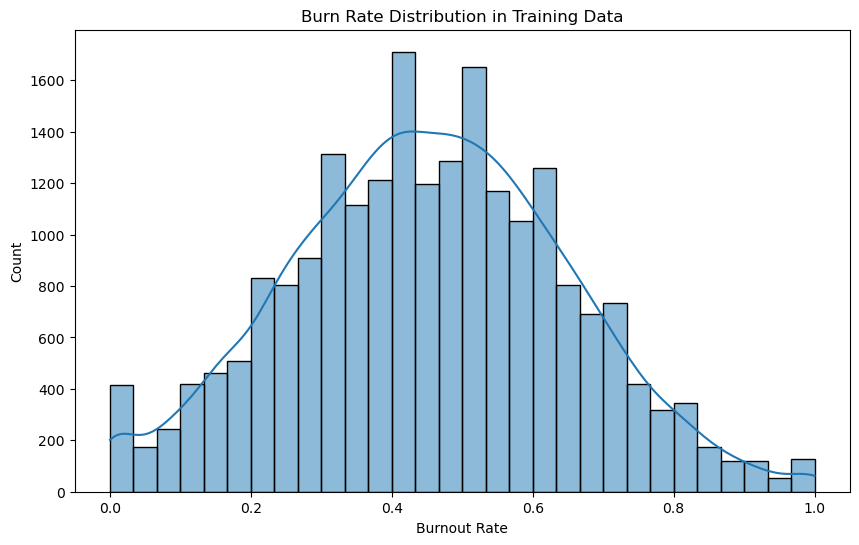

In [5]:
#1: Data Loading & Initial Inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_df = pd.read_csv(r"C:\Users\Mr. Louis\Downloads\train.csv")
test_df = pd.read_csv(r"C:\Users\Mr. Louis\Downloads\test.csv")

print(f"Training data: {train_df.shape}")
print(f"Testing data: {test_df.shape}")

# Check target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Burn Rate'], kde=True, bins=30)
plt.title('Burn Rate Distribution in Training Data')
plt.xlabel('Burnout Rate')
plt.savefig('burn_rate_dist.png')
plt.show()

C:\Users\Mr. Louis\AppData\Local\Temp\ipykernel_10340\2926506984.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')


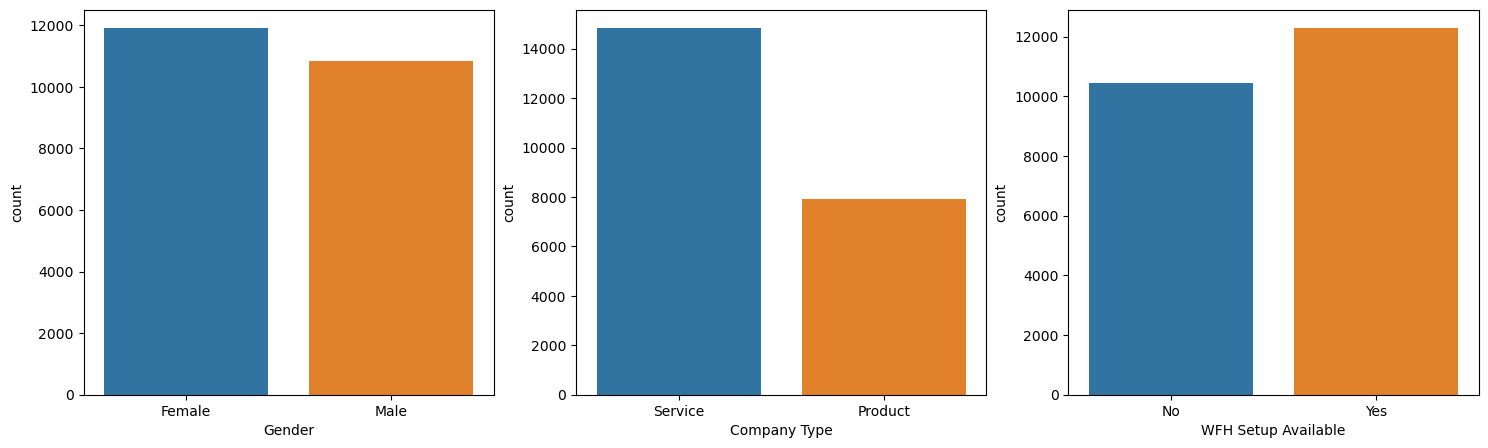

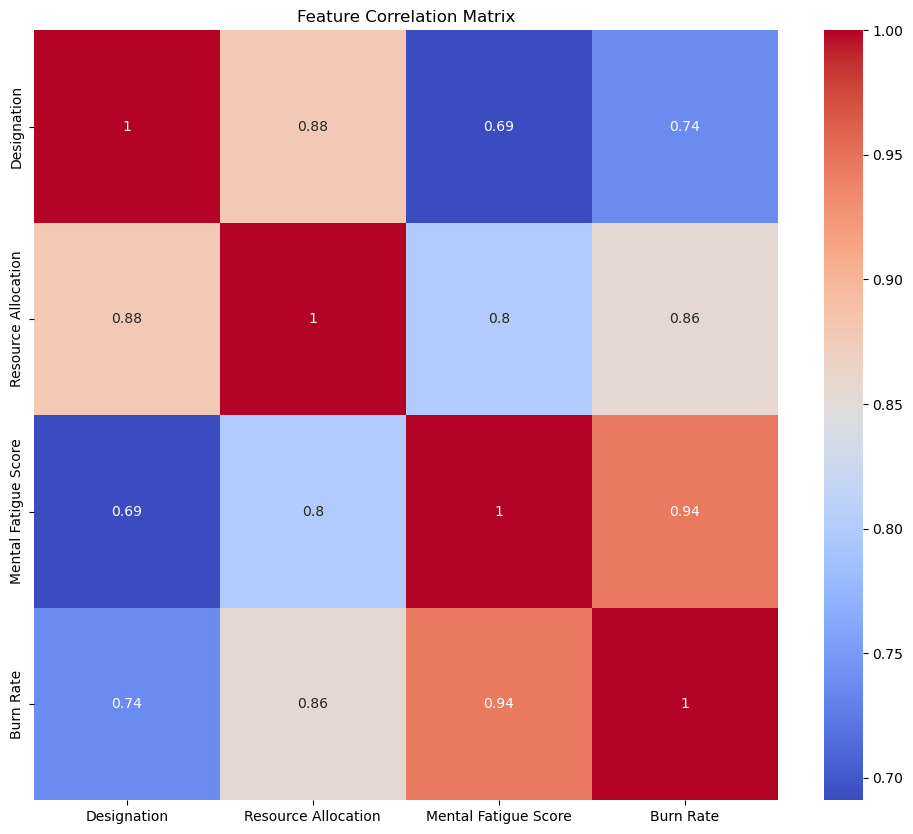

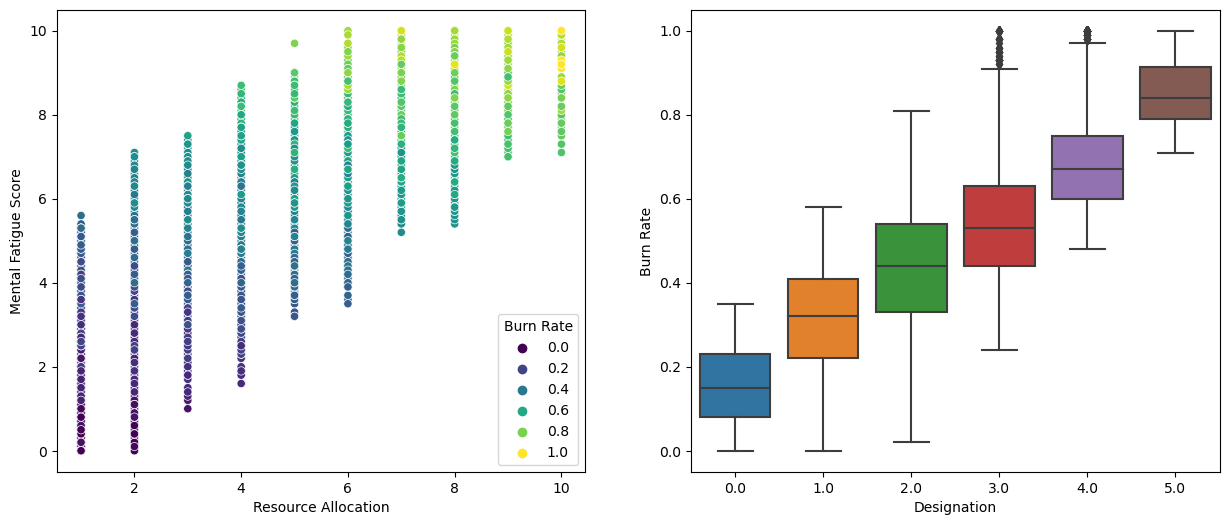

In [6]:
#  Exploratory Data Analysis (EDA)
# 1. Missing values analysis
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()

# 2. Categorical variables distribution
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=train_df, x='Gender', ax=ax[0])
sns.countplot(data=train_df, x='Company Type', ax=ax[1])
sns.countplot(data=train_df, x='WFH Setup Available', ax=ax[2])
plt.savefig('categorical_dist.png')

# 3. Numerical relationships
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')

# 4. Target variable relationships
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=train_df, x='Resource Allocation', y='Mental Fatigue Score', 
                hue='Burn Rate', palette='viridis', ax=ax[0])
sns.boxplot(data=train_df, x='Designation', y='Burn Rate', ax=ax[1])
plt.savefig('target_relationships.png')

In [11]:
# Data Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Feature engineering
for df in [train_df, test_df]:
    df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])
    df['Tenure'] = (pd.to_datetime('2009-01-01') - df['Date of Joining']).dt.days
    df['Workload Score'] = df['Resource Allocation'] * df['Designation']

# Define preprocessing
num_features = ['Designation', 'Resource Allocation', 'Mental Fatigue Score', 'Tenure', 'Workload Score']
cat_features = ['Gender', 'Company Type', 'WFH Setup Available']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ])

# Apply preprocessing
X_train = preprocessor.fit_transform(train_df)
y_train = train_df['Burn Rate']
X_test = preprocessor.transform(test_df)

# Save preprocessed data
pd.DataFrame(X_train).to_csv('preprocessed_train.csv', index=False)
pd.DataFrame(X_test).to_csv('preprocessed_test.csv', index=False)

In [8]:
# Model Development
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=150, learning_rate=0.1),
    'Ridge Regression': Ridge(alpha=0.5)
}

# Model evaluation
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    results[name] = {
        'r2_mean': np.mean(scores),
        'r2_std': np.std(scores)
    }
    print(f"{name} | R²: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Select best model (Gradient Boosting typically performs best)
final_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.08, max_depth=4)
final_model.fit(X_train, y_train)

# Feature importance analysis
features = num_features + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features))
importances = final_model.feature_importances_

plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=features, palette='rocket')
plt.title('Feature Importance Analysis')
plt.savefig('feature_importance.png')

ValueError: Input y contains NaN.

In [10]:
# Deployment & Insights
import streamlit as st
import joblib

# Load model
model = joblib.load('burnout_model.pkl')
preprocessor = joblib.load('preprocessor.pkl')

st.title('NeuroWell Employee Burnout Predictor')

# Input widgets
gender = st.selectbox('Gender', ['Female', 'Male'])
company_type = st.selectbox('Company Type', ['Service', 'Product'])
wfh = st.selectbox('WFH Setup Available', ['No', 'Yes'])
designation = st.slider('Designation Level', 0.0, 5.0, 2.0)
resources = st.slider('Resource Allocation (hours/day)', 1.0, 10.0, 5.0)
fatigue = st.slider('Mental Fatigue Score', 0.0, 10.0, 5.0)
join_date = st.date_input('Date of Joining')

if st.button('Predict Burnout Risk'):
    input_data = pd.DataFrame([[join_date, gender, company_type, wfh, designation, resources, fatigue]],
                              columns=['Date of Joining', 'Gender', 'Company Type', 'WFH Setup Available', 
                                       'Designation', 'Resource Allocation', 'Mental Fatigue Score'])
    # Preprocess
    processed = preprocessor.transform(input_data)
    # Predict
    burnout = model.predict(processed)[0]
    # Visualize
    st.progress(int(burnout*100))
    st.subheader(f'Predicted Burnout Risk: {burnout:.2f}')
    if burnout > 0.7:
        st.error('High burnout risk! Recommend immediate intervention')
    elif burnout > 0.4:
        st.warning('Moderate burnout risk - monitor closely')
    else:
        st.success('Low burnout risk - maintain current practices')

ModuleNotFoundError: No module named 'streamlit'